In [79]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import datasets, transforms
import random
import numpy as np
import matplotlib.pyplot as plt



üì¢ Affichage des disponibilit√©s des workers avant la simulation...


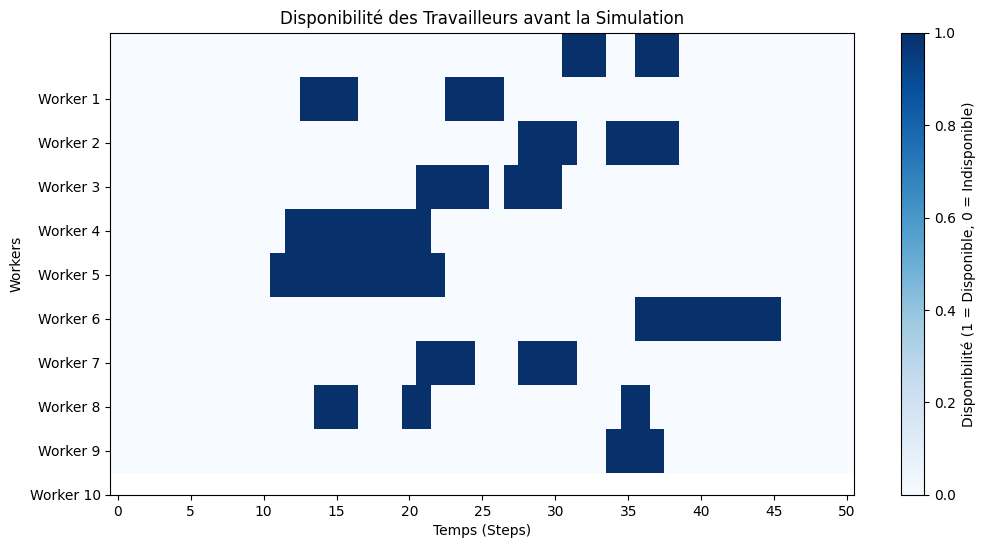

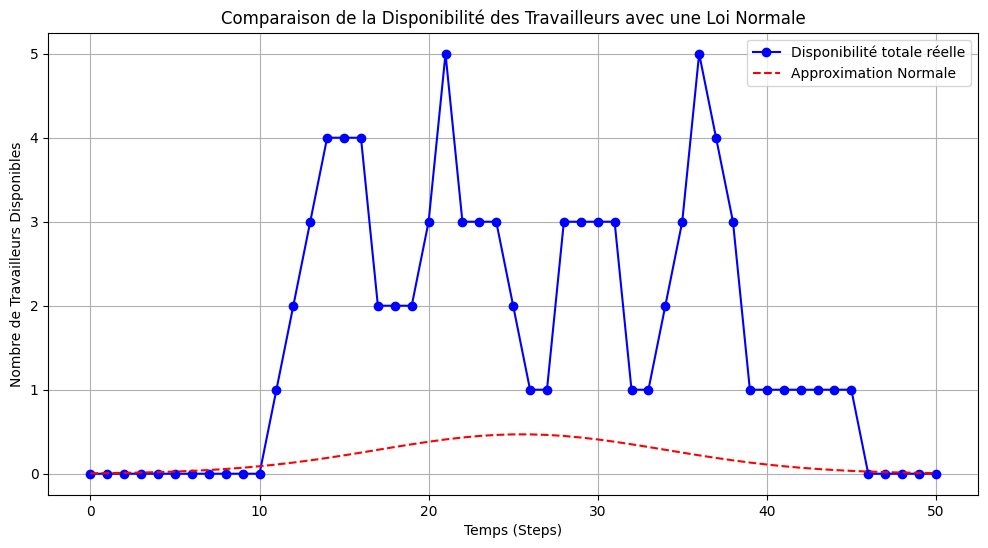

üì¢ D√©marrage de la simulation...
üîÑ Worker 1 disponible aux p√©riodes [(31, 34), (36, 39)] | Temps de traitement : 2
üîÑ Worker 2 disponible aux p√©riodes [(13, 17), (23, 27)] | Temps de traitement : 4
üîÑ Worker 3 disponible aux p√©riodes [(28, 32), (34, 39)] | Temps de traitement : 4
üîÑ Worker 4 disponible aux p√©riodes [(21, 26), (27, 31)] | Temps de traitement : 2
üîÑ Worker 5 disponible aux p√©riodes [(12, 22)] | Temps de traitement : 4
üîÑ Worker 6 disponible aux p√©riodes [(11, 23)] | Temps de traitement : 4
üîÑ Worker 7 disponible aux p√©riodes [(36, 46)] | Temps de traitement : 4
üîÑ Worker 8 disponible aux p√©riodes [(21, 25), (28, 32)] | Temps de traitement : 4
üîÑ Worker 9 disponible aux p√©riodes [(14, 17), (20, 22), (35, 37)] | Temps de traitement : 2
üîÑ Worker 10 disponible aux p√©riodes [(34, 38)] | Temps de traitement : 4

‚è≥ Temps 0
üìä [T=0] Pr√©cision du mod√®le: 9.33%

‚è≥ Temps 1

‚è≥ Temps 2

‚è≥ Temps 3

‚è≥ Temps 4

‚è≥ Temps 5
üìä [T=5] Pr√©

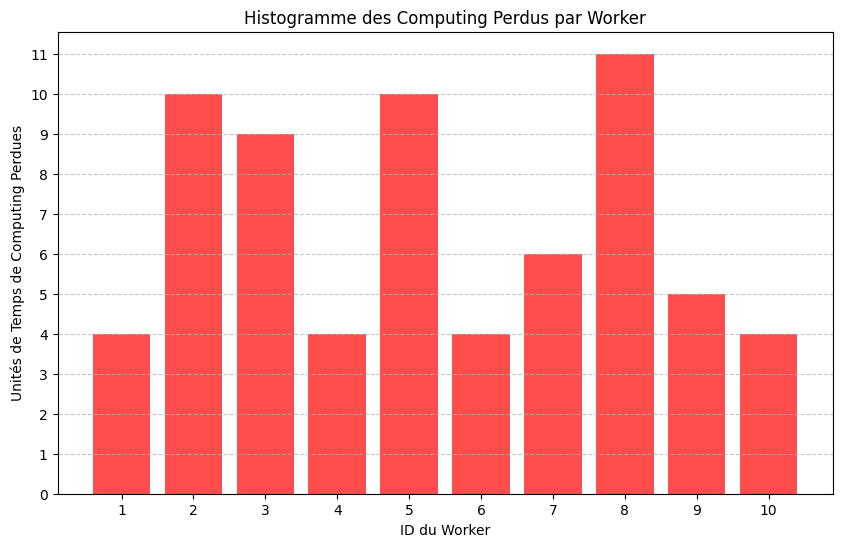

In [80]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import datasets, transforms
import random
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------------------------
# Fusionne les intervalles qui se chevauchent ou sont adjacents.
def merge_intervals(intervals):
    if not intervals:
        return []
    intervals.sort()
    merged = [intervals[0]]
    for current in intervals[1:]:
        last = merged[-1]
        if current[0] <= last[1]:
            merged[-1] = (last[0], max(last[1], current[1]))
        else:
            merged.append(current)
    return merged

# ------------------------------------------------------------------------------
# G√©n√®re des disponibilit√©s selon une loi normale centr√©e autour d'un moment moyen,
# en s'assurant que chaque intervalle a une dur√©e minimale >= min_processing_time.
def generate_normal_availability(max_time, mean, std_dev, max_periods=5, min_processing_time=2):
    availability_periods = []
    num_periods = random.randint(1, max_periods)
    for _ in range(num_periods):
        start_time = int(np.clip(np.random.normal(mean, std_dev), 0, max_time - min_processing_time))
        # La dur√©e est au moins min_processing_time et bas√©e sur une distribution normale (valeur absolue)
        duration = max(min_processing_time, int(np.abs(np.random.normal(3, 2))))
        end_time = start_time + duration
        end_time = min(end_time, max_time)
        if end_time - start_time >= min_processing_time:
            availability_periods.append((start_time, end_time))
    return merge_intervals(availability_periods)

# ------------------------------------------------------------------------------
# D√©finition du mod√®le de r√©seau de neurones
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# ------------------------------------------------------------------------------
# Gestionnaire de mini-batches avec SubsetRandomSampler
class BatchManager:
    def __init__(self, dataset, batch_size):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indices = list(range(len(dataset)))
        random.shuffle(self.indices)
        self.sampler = SubsetRandomSampler(self.indices)
        self.loader = iter(DataLoader(self.dataset, batch_size=self.batch_size, sampler=self.sampler))
    def get_next_batch(self):
        try:
            return next(self.loader)
        except StopIteration:
            random.shuffle(self.indices)
            self.sampler = SubsetRandomSampler(self.indices)
            self.loader = iter(DataLoader(self.dataset, batch_size=self.batch_size, sampler=self.sampler))
            return next(self.loader)

# ------------------------------------------------------------------------------
# Classe Worker : g√®re le calcul local des gradients
class Worker:
    def __init__(self, model, device, worker_id, availability_periods, processing_time):
        self.device = device
        self.worker_id = worker_id
        self.availability_periods = availability_periods
        self.processing_time = processing_time
        self.model = model.to(device)
        self.criterion = nn.CrossEntropyLoss()
        self.finish_time = None
        self.current_batch_id = None
    def is_available(self, current_time):
        for start_time, end_time in self.availability_periods:
            if start_time <= current_time < end_time:
                if self.finish_time is None or current_time >= self.finish_time:
                    return (current_time + self.processing_time) <= end_time
        return False
    def start_computation(self, current_time, batch_id, data, targets):
        if self.current_batch_id is None or self.current_batch_id != batch_id:
            self.current_batch_id = batch_id
            self.finish_time = current_time + self.processing_time
            print(f"üöÄ [T={current_time}] Worker {self.worker_id} commence un NOUVEAU calcul sur batch {batch_id}.")
            return self.compute_gradient(data, targets)
        return None
    def has_finished(self, current_time):
        return self.finish_time == current_time
    def compute_gradient(self, data, targets):
        data, targets = data.to(self.device), targets.to(self.device)
        self.model.zero_grad()
        outputs = self.model(data)
        loss = self.criterion(outputs, targets)
        loss.backward()
        gradients = {name: param.grad.detach().clone() for name, param in self.model.named_parameters()}
        return gradients, self.current_batch_id
    def update_model(self, model_state_dict):
        self.model.load_state_dict(model_state_dict)

# ------------------------------------------------------------------------------
# Serveur central : g√®re l'application des gradients
class Server:
    def __init__(self, dataset, batch_size=64, lr=0.001):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = SimpleNN().to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.batch_manager = BatchManager(dataset, batch_size)
        self.current_batch = None
        self.current_batch_id = 0
        self.model_updated = True
        self.worker_contributions = {}
        # Pour stocker le temps de computing perdu par worker (en unit√©s de temps discret)
        self.wasted_gradients = {}  
        self.batch_send_times = {}  # Enregistre le temps d'envoi de chaque batch
        self.total_wasted_time = 0  # Temps total de computing perdu

    def update_global_model(self, worker_gradients, batch_id, worker_id, current_time):
        """
        Applique les gradients si le batch est encore valide.
        Sinon, calcule le temps perdu (current_time - send_time) et l'ajoute au computing perdu pour ce worker.
        """
        if worker_gradients is None or batch_id != self.current_batch_id:
            send_time = self.batch_send_times.get(batch_id, current_time)
            wasted = current_time - send_time
            print(f"üö® Ignor√©: Batch {batch_id} d√©j√† trait√© pour Worker {worker_id}. Temps perdu: {wasted}")
            # On accumule le temps perdu pour ce worker
            self.wasted_gradients[worker_id] = self.wasted_gradients.get(worker_id, 0) + wasted
            self.total_wasted_time += wasted
            return
        self.optimizer.zero_grad()
        for name, param in self.model.named_parameters():
            param.grad = worker_gradients[name]
        self.optimizer.step()
        print(f"üîÑ Mod√®le mis √† jour avec Batch {batch_id} gr√¢ce √† Worker {worker_id}.")
        self.worker_contributions[worker_id] = self.worker_contributions.get(worker_id, 0) + 1
        self.model_updated = True

    def compute_wasted_computing_time(self):
        # Renvoie simplement le temps total accumul√©
        return self.total_wasted_time

    def print_worker_statistics(self):
        print("\nüìä R√©sum√© des contributions utiles des workers :")
        sorted_contrib = sorted(self.worker_contributions.items(), key=lambda x: x[1], reverse=True)
        for worker_id, count in sorted_contrib:
            print(f"üîπ Worker {worker_id} a contribu√© {count} fois √† la mise √† jour du mod√®le.")
        print("\nüìä R√©sum√© des wasted computing (temps perdu) :")
        sorted_wasted = sorted(self.wasted_gradients.items(), key=lambda x: x[1], reverse=True)
        for worker_id, wasted_time in sorted_wasted:
            print(f"üîπ Worker {worker_id} a perdu {wasted_time} unit√©s de temps de computing.")
        wasted_time_total = self.compute_wasted_computing_time()
        print(f"\n‚è≥ Temps total de computing perdu : {wasted_time_total} unit√©s de temps.")

    def get_batch_for_worker(self, current_time):
        """Renvoie le m√™me batch tant que le mod√®le n'a pas √©t√© mis √† jour et enregistre le temps d'envoi."""
        if self.model_updated:
            self.current_batch = self.batch_manager.get_next_batch()
            self.current_batch_id += 1
            self.batch_send_times[self.current_batch_id] = current_time
            self.model_updated = False
        return self.current_batch, self.current_batch_id

    def evaluate(self, test_loader):
        self.model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data, targets in test_loader:
                data, targets = data.to(self.device), targets.to(self.device)
                outputs = self.model(data)
                _, predicted = torch.max(outputs.data, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()
        return 100 * correct / total

    def plot_wasted_computing(self):
        """Affiche un histogramme des unit√©s de temps de computing perdues par worker."""
        if not self.wasted_gradients:
            print("‚úÖ Aucun computing perdu √† afficher.")
            return
        
        worker_ids = list(self.wasted_gradients.keys())
        wasted_times = list(self.wasted_gradients.values())

        plt.figure(figsize=(10, 6))
        plt.bar(worker_ids, wasted_times, color='red', alpha=0.7)
        plt.xlabel("ID du Worker")
        plt.ylabel("Unit√©s de Temps de Computing Perdues")
        plt.title("Histogramme des Computing Perdus par Worker")
        plt.xticks(worker_ids)
        plt.yticks(np.arange(0, max(wasted_times) + 1, step=1))
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()




# ------------------------------------------------------------------------------
# Simulation d'apprentissage f√©d√©r√© avec affichage des statistiques et disponibilit√©s
class DiscreteEventSimulator:
    def __init__(self, server, workers, test_loader, total_time_steps=20):
        self.server = server
        self.workers = workers
        self.test_loader = test_loader
        self.total_time_steps = total_time_steps
        self.global_time = 0
        self.worker_computing = []
    def plot_worker_availability(self):
        num_workers = len(self.workers)
        total_time_steps = self.total_time_steps
        availability_data = [(worker.worker_id, worker.availability_periods) for worker in self.workers]
        time_grid = np.zeros((num_workers, total_time_steps))
        for worker_id, periods in availability_data:
            for start, end in periods:
                time_grid[worker_id - 1, start:end] = 1
        plt.figure(figsize=(12, 6))
        plt.imshow(time_grid, aspect="auto", cmap="Blues", interpolation="nearest")
        plt.xlabel("Temps (Steps)")
        plt.ylabel("Workers")
        plt.title("Disponibilit√© des Travailleurs avant la Simulation")
        plt.xticks(range(0, total_time_steps, max(1, total_time_steps // 10)))
        plt.yticks(range(1, num_workers + 1), [f"Worker {i}" for i in range(1, num_workers + 1)])
        plt.colorbar(label="Disponibilit√© (1 = Disponible, 0 = Indisponible)")
        plt.show()
        availability_counts = np.sum(time_grid, axis=0)
        mean_time = total_time_steps / 2
        std_dev_time = total_time_steps / 6
        x = np.arange(total_time_steps)
        normal_distribution = num_workers * (1 / (std_dev_time * np.sqrt(2 * np.pi))) * \
                              np.exp(-((x - mean_time) ** 2) / (2 * std_dev_time ** 2))
        plt.figure(figsize=(12, 6))
        plt.plot(x, availability_counts, marker='o', linestyle='-', label="Disponibilit√© totale r√©elle", color='blue')
        plt.plot(x, normal_distribution, linestyle='--', label="Approximation Normale", color='red')
        plt.xlabel("Temps (Steps)")
        plt.ylabel("Nombre de Travailleurs Disponibles")
        plt.title("Comparaison de la Disponibilit√© des Travailleurs avec une Loi Normale")
        plt.legend()
        plt.grid()
        plt.show()

    def run(self):
        print("üì¢ Affichage des disponibilit√©s des workers avant la simulation...")
        self.plot_worker_availability()
        print("üì¢ D√©marrage de la simulation...")
        
        for worker in self.workers:
            print(f"üîÑ Worker {worker.worker_id} disponible aux p√©riodes {worker.availability_periods} | Temps de traitement : {worker.processing_time}")
        
        while self.global_time < self.total_time_steps:
            print(f"\n‚è≥ Temps {self.global_time}")
            
            newly_finished_workers = [worker for worker in self.worker_computing if worker.has_finished(self.global_time)]
            for worker in newly_finished_workers:
                self.worker_computing.remove(worker)
                batch, _ = self.server.get_batch_for_worker(self.global_time)
                data, targets = batch
                gradients, batch_id = worker.compute_gradient(data, targets)
                self.server.update_global_model(gradients, batch_id, worker.worker_id, self.global_time)
            
            available_workers = [worker for worker in self.workers if worker.is_available(self.global_time) and worker not in self.worker_computing]
            for worker in available_workers:
                batch, batch_id = self.server.get_batch_for_worker(self.global_time)
                data, targets = batch
                worker.start_computation(self.global_time, batch_id, data, targets)
                self.worker_computing.append(worker)
            
            if self.global_time % 5 == 0:
                accuracy = self.server.evaluate(self.test_loader)
                print(f"üìä [T={self.global_time}] Pr√©cision du mod√®le: {accuracy:.2f}%")
            self.global_time += 1

        print("üèÅ Simulation termin√©e !")
        self.server.print_worker_statistics()
        self.server.plot_wasted_computing()

# ------------------------------------------------------------------------------
# Chargement des donn√©es
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# ------------------------------------------------------------------------------
# Initialisation du serveur et des workers
server = Server(train_dataset)
workers = []
for i in range(1, 11):
    processing_time = random.randint(2, 4)
    availability = generate_normal_availability(50, mean=random.randint(10, 40), std_dev=6, max_periods=5, min_processing_time=processing_time)
    workers.append(Worker(server.model, server.device, i, availability, processing_time))

# ------------------------------------------------------------------------------
# Lancement de la simulation avec 51 steps
simulator = DiscreteEventSimulator(server, workers, test_loader, total_time_steps=51)
simulator.run()
